<a href="https://colab.research.google.com/github/aysiacobb/EnvDatSci/blob/main/Copy_of_RasterData101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Raster Data 101
In this lesson you will learn more about working with two types of spatial raster data: a LiDAR derived digital elevation model (DEM), and high-resolution 4-band orthoimagery collected by the USDA National Agricultural Imagery Program (NAIP) from aircraft.

We'll be using a raster virtualization package called *rasterio*. This package allows us to use numpy matrix arithmetic and algebraic functions on raster data.

If you want to read more about LiDAR data and how it is used to build raster based surface models, you can check out this chapter: https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/

If you are interested in learning more about, or accessing, NAIP data, check here: https://www.usgs.gov/centers/eros/science/usgs-eros-archive-aerial-photography-national-agriculture-imagery-program-naip

### Adapted from:
**Lesson 2. Open, Plot and Explore Raster Data with Python
*by Leah Wasser, Chris Holdgraf, Martha Morrissey***
https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python/

**Working with Raster Data
*by Zia U Ahmed***
https://zia207.github.io/geospatial-python.io/lesson_06_working-with-raster-data.html


In [ ]:
#attach to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install packages for Google Colab
%%capture
!pip install rasterio
!pip install earthpy

In [ ]:
# Import necessary packages
import os
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import plotting_extent
import numpy as np
import earthpy as et
import earthpy.plot as ep

## Download and open raster data
We are going to be working with two different raster datasets today. The first is a LiDAR derived digital elevation model (DEM) that was created using NEON (the National Ecological Observatory Network) data. A DEM represents elevation for each pixel. DEMs are also sometimes referred to as Digital Terrain Models or DTMs.

In [ ]:
# Get data offline using earthpy package, and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

Extracted output to /root/earth-analytics/data/colorado-flood/.


In [ ]:
# Define relative path to file
dem_pre_path = os.path.join("colorado-flood",
                            "spatial",
                            "boulder-leehill-rd",
                            "pre-flood",
                            "lidar",
                            "pre_DTM.tif")

# Open the file using a context manager ("with rio.open" statement)
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)

## Explore Raster Data Values & Structure
You may notice that the code above used to open a raster file is a bit more complex than the code that you used to open vector files (shapefiles) with geopandas or tabular data with pandas. The with rio.open() statement creates what is called a *context manager* for opening files. This allows you to create a connection to the file without modifying the file itself.

You can learn more about context managers in [Chapter 3 of the Intermediate Earth Data Science in Python Textbook](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python-xarray/)

Start by taking a look at the data. Notice that the data structure or `type()` returned by rasterio is a numpy array.

In [ ]:
#What object type did we create with that call? Numpy Array
type(dtm_pre_arr)

numpy.ndarray

A few notes about rasters:

* Each cell, defined by a unique row and column, is called a pixel.
* Each pixel is associated with a coordinate value. Pixels can be georeferenced to their centroid or any corner.
* Each pixel represents a fixed area on earth's surface.
* The resolution of the raster represents the area that each pixel represents on the ground. So, a 1 meter resolution raster, means that each pixel represents a 1 m by 1 m area on the ground.


Each pixel has a value associated with it representing some attribute of space. For instance in a LiDAR derived digital elevation model (DEM), each cell represents an elevation value for that location on earth's surface. In a LIDAR derived intensity image, each cell represents a LiDAR intensity, or the amount of light energy returned to and recorded by the sensor.

When you open raster data using `rasterio` you are creating a numpy array. Numpy is an efficient way to work with and process raster format data.

In [ ]:
#For eample, using numpy commands, we can determine the dimensions of our raster:
dtm_pre_arr.shape

(2000, 4000)

In [ ]:
# We can determine the minimum and maximum values of our raster dataset as well.
print("the minimum raster value is: ", dtm_pre_arr.min())
print("the maximum raster value is: ", dtm_pre_arr.max())

the minimum raster value is:  -3.4028235e+38
the maximum raster value is:  2087.43


### TASK 1: In your own words, describe what physical (real world) values the outputs of the `shape`, `min`, and `max` functions correspond to.

Min and max functions could correspond to the lowest and highest elevation points in the 'real world'. Shape may correspond to the area that is being researched in the file.

## Plotting in rasterio:

You can plot your data using earthpy `plot_bands()` which takes a numpy array as an input and generates a plot.

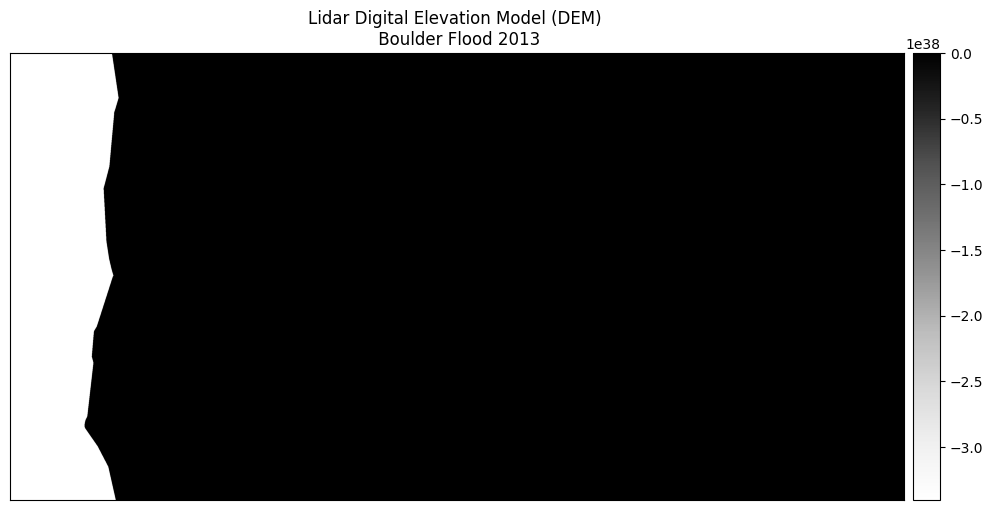

In [ ]:
# Plot your data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()

The data above should represent terrain model data. However, the range of values is not what is expected. These data are for Boulder, Colorado where the elevations range between 1000-3000m.

There may be some outlier values in the data that may need to be addressed. Below you check out the min and max values of the data.

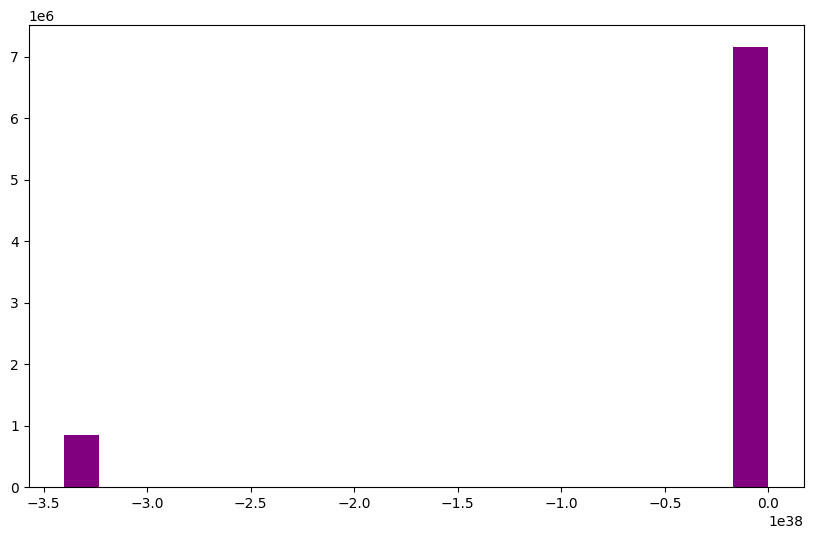

In [ ]:
# A histogram can also be helpful to look at the range of values in your data
# What do you notice about the histogram below? No clear distribution at all more like two points at extreme values (low and high)
ep.hist(dtm_pre_arr,
        figsize=(10, 6))
plt.show()

Histogram for your LiDAR DTM. Notice the number of values that are below 0.

Looking at the minimum value of the data, there are one of two things going on that need to be fixed:

1. There may be no data values in the data that are stored with a negative value that are skewing your plot colors
2. There also could be outlier data in your raster

You can explore the first option - that there are no data values by reading in the data and masking no data values using rasterio. To do this, you will use the masked=True parameter for the .read() function - like this:

In [ ]:
# Read in your data and mask the no data values
with rio.open(dem_pre_path) as dem_src:
    # Masked=True will mask all no data values
    dtm_pre_arr = dem_src.read(1, masked=True)

Notice that now the minimum value looks more like an elevation value (which should most often not be negative).

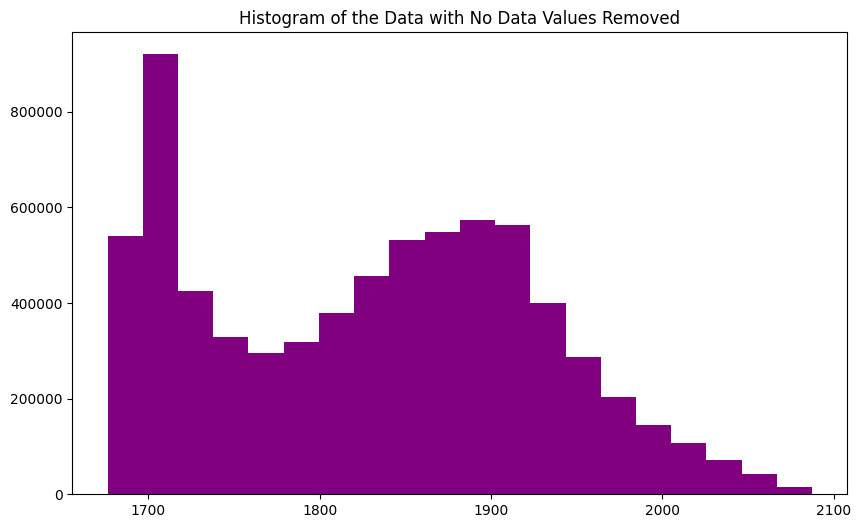

In [ ]:
# A histogram can also be helpful to look at the range of values in your data
ep.hist(dtm_pre_arr,
        figsize=(10, 6),
        title="Histogram of the Data with No Data Values Removed")
plt.show()

Plot your data again to see how it looks:

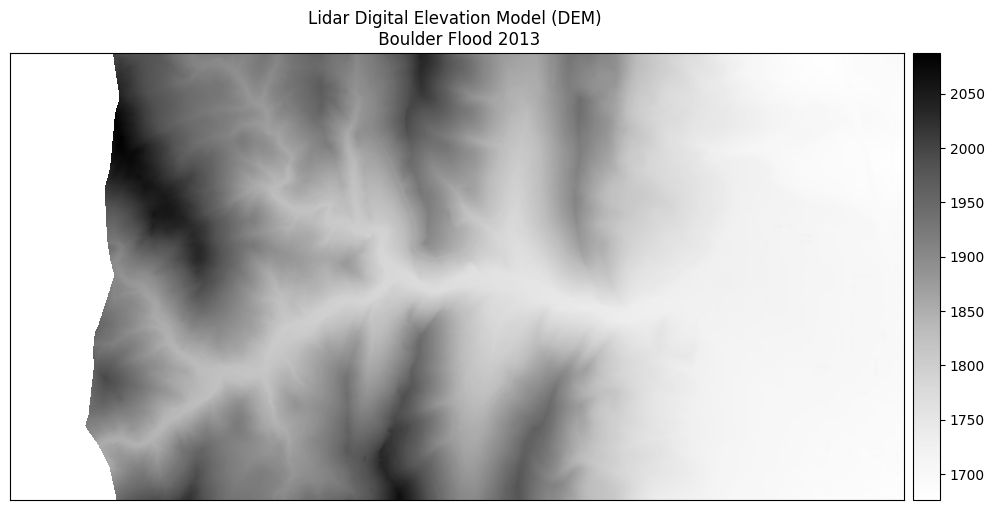

In [ ]:
# Plot data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()

### TASK 2: Look closely at the plot above. What do you think the colors and numbers represent in the plot? What units do the numbers represent? What does the abrupt white line on the left side of the plot represent?

I believe the number and colors represent the elevation values/levels. The units for the numbers of the left are not displayed, however in previous texts (m) was used to describe the elevation, so meters can be assumed again. The abrupt white line on the left side of the plot may represent the end of the raster data file, which is why it is so abrupt.

In [ ]:
type(dtm_pre_arr)

numpy.ma.core.MaskedArray

The numpy array below is type `numpy.ma.core.MaskedArray`. It is a *masked* array. We use a value format indicating no data to populate pixels where we lack measurements. The online documentation for the `mask` option in rasterio can be accessed [here](https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html).

How we digitally encode missing measurements is a substantial component of data management. More information on managing missing data in pandas and numpy can be found in the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html)

### TASK 3: What is a no data value? Why is this an important data format for handling raster data?

In raster data, a no data valuue is a pixel value in a raster or vector map that represents a lack of information. It is an important data format for handling raster data becaus it represents missing data which is able to be preserved and processed correctly.

### Context Managers to Open and Close File Connections
The with `rio.open()` function creates what is known as a context manager. A context manager is a highly efficient way to work with large raster datasets. With a context manager, python makes a temporary connection to the file that you are trying to open, rather than reading it into memory. This means that you can access very large raster files using python, even on computers with limited RAM.

Once you are done opening and reading in the data, the context manager closes that connection to the file. This ensures that the original file won’t be by your code.
```
with rio.open(`file-path-here`) as file_src:
    dtm_pre_arr = dem_src.read(1, masked=True)
```
To break this code down, the context manager has a few parts. First, it has a with statement. The with statement creates a connection to the file that you want to open. The default connection type is read only. This means that you can NOT modify that file by default. Not being able to modify the original data is a good thing because it prevents you from making unintended changes to your original data.

#### Notice that the first line of the context manager is not indented. It contains two parts

1. `rio.open()`: This is the code that will open a connection to your .tif file using a path you provide.
file_src: this is a rasterio reader object that you can use to read in the actual data. You can also use this object to access the metadata for the raster file.

2. The second line of your with statement `dtm_pre_arr = dem_src.read(1, masked=True)` is indented. Any code that is indented directly below the with statement will become a part of the context manager. This code has direct access to the file_src object which is you recall above is the rasterio reader object.


You can get a better understanding of how the rasterio context manager works by taking a look at what it is doing line by line. Start by looking at the dem_pre_path object. Notice that this object is a path to the file pre_DEM.tif. The context manager needs to know where the file is that you want to open with Rasterio.

In [ ]:
# Look at the path to your dem_pre file
dem_pre_path

'colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif'

Now use the dem_pre_path in the context manager to open and close your connection to the file. Notice that if you print the “src” object within the context manager (notice that the print statement is indented which is how you know that you are inside the context manager), the returl is an open DatasetReader

The name of the reader is the path to your file. This means there is an open and active connection to the file.

In [ ]:
# Opening the file with the dem_pre_path
# Notice here the src object is printed and returns an "open" DatasetReader object
with rio.open(dem_pre_path) as src:
    print(src)

<open DatasetReader name='colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif' mode='r'>


If you print that same src object outside of the context manager, notice that it is now a closed datasetReader object. It is closed because it is being called outside of the context manager. Once the connection is closed, you can no longer access the data. This is a good thing as it protects you from inadvertently modifying the file itself!

Now look at what .read() does. Below you use the context manager to both open the file and read it. See that the read() method, returns a numpy array that contains the raster cell values in your file.

In [ ]:
# Open the file using a context manager and get the values as a numpy array with .read()
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)


In [ ]:
# View numpy array of your data
dtm_pre_arr

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956300e+03,  1.6954199e+03,  1.6954299e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956000e+03,  1.6955399e+03,  1.6953600e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6953800e+03,  1.6954399e+03,  1.6953700e+03],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6814500e+03,  1.6813900e+03,  1.6812500e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6817200e+03,  1.6815699e+03,  1.6815599e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6818900e+03,  1.6818099e+03,  1.6817400e+03]], dtype=float32)

Because you created an object within the context manager that contains those raster values as a numpy array, you can now access the data values without needing to have an open connection to your file. This ensures once again that you are not modifying your original file and that all connections to it are closed. You are now free to play with the numpy array and process your data!


You can use the .profile attribute to create an object with metadata on your raster image. The metadata object below contains information like the coordinate reference system and size of the raster image.

In [ ]:
with rio.open(dem_pre_path) as dem_src:
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_meta = dem_src.profile

lidar_dem_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

## How rasterio associates location with numpy pixels

When you call `src.read()` above, rasterio is reading in the data as a numpy array. A numpy array is a matrix of values. Numpy arrays are an efficient structure for working with large and potentially multi-dimensional (layered) matrices. The `src.profile()` function gives you the information you need to translate from rows and columns in the numpy array to latitude and longitude in real world coordinates.

The `crs` parameter tells you which coordinate reference system your data is stored in. More on this later.

The six paramters in the `Affine` parameter translate to the following real world values:

0. width of a pixel
1. row rotation (typically zero)
2. x-coordinate of the upper-left corner of the upper-left pixel
3. column rotation (typically zero)
4. height of a pixel (typically negative)
5. y-coordinate of the of the upper-left corner of the upper-left pixel

We're breaking our geotiff down into two parts: a numpy array representing the data values for each pixel in our raster dataset, and the spatial metadata required to assign spatial coordiantes to this data.

In [ ]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)

print("Numpy Array Shape:", lidar_dem_im.shape)
print("Object type:", type(lidar_dem_im))

Numpy Array Shape: (2000, 4000)
Object type: <class 'numpy.ma.core.MaskedArray'>


In summary:
* A numpy array does not by default store spatial information. However, your raster data is spatial - it represents a location on the earth’s surface.

* You can acccess the spatial metadata within the context manager using `dem_src.profile`.

* Notice that the .profile object contains information including the no data values for your data, the shape, the file type and even the coordinate reference system.

You will learn more about raster metadata in our next class, but also see this chapter: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/raster-metadata-in-python/

## Raster calculations
We love having our raster dataset stored as a numpy array because it allows us to use arithmetic and matrix algebra to derive information from our data. Common examples could include scaling data (changing units, apply a log transform, subtracting the mean and dividing by the standard deviation, setting the min and max value to 0 and 1 respectively but preserving the distribution), setting unrealistic values to NAs (for example, cloud masking), or reclassifying data, or creating categories representing features of interest on earth's surface. Categorization can be made using simple thresholds on pixel value distributions, or using more complex methods like eigenvalue decomposition. The fact that our raster data exists as a numpy array makes these types of operations simple and computationally lightweight.


In [ ]:
# read in data and metadata through raster connection
with rio.open(dem_pre_path) as dem_src:
    dem_data = dem_src.read(1)
    dem_meta = dem_src.profile

You can learn more about working with numpy arrays in [Lesson 1 of the Introductory Earth Data Science in Python Textbook](https://www.earthdatascience.org/courses/intro-to-earth-data-science/scientific-data-structures-python/numpy-arrays/), or on the Python101 notebook in this repository.

### TASK 4: dem_data above is reported in meters. Create a new raster, dem_feet, with units of feet.

*Note: there are 3.28084 feet per meter*

In [ ]:
#Task 4:
dem_feet =  dem_data * 3.28084

<ipython-input-26-21accf186948>:2: RuntimeWarning: overflow encountered in multiply
  dem_feet =  dem_data * 3.28084


View the summary statistics for the dem_feet array you created under task 4.

In [ ]:
#View values:
dem_feet.min(), dem_feet.max()

(-inf, 6848.5234)

Here, a numpy negative infinity value, or `-np.inf`, represents invalid data. We must assign a no-data value to this pixel to prevent misinterpreting the dataset. We can create a no-data mask using rasterio and apply it to our virtual data as well.

In [ ]:
#Mask out negative infinity
dem_feet_ma = np.ma.masked_where(dem_feet == -np.inf,
                                        dem_feet,
                                        copy=True)
dem_feet_ma

masked_array(
  data=[[--, --, --, ..., 5563.0908203125, 5562.4013671875,
         5562.43408203125],
        [--, --, --, ..., 5562.9921875, 5562.794921875, 5562.20458984375],
        [--, --, --, ..., 5562.2705078125, 5562.46728515625,
         5562.23779296875],
        ...,
        [--, --, --, ..., 5516.568359375, 5516.37158203125,
         5515.912109375],
        [--, --, --, ..., 5517.4541015625, 5516.9619140625,
         5516.92919921875],
        [--, --, --, ..., 5518.01171875, 5517.7490234375, 5517.51953125]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)

Note: we did not use masked = T when we read in the dem.

### TASK 5: How could we read in dem_data with a mask so that we don't have to remove the -np.inf values?

In [ ]:
#Task 5:

# read in raw dem data and metadata through raster connection
with rio.open(dem_pre_path) as dem_src:
    dem_data = dem_src.read(1, masked=True)
    dem_meta = dem_src.profile

# use dem_data to create dem_feet_ma
dem_feet_ma = dem_data * 3.28084

# print out min and max values
dem_feet_ma.min()
dem_feet_ma.max()

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


6848.5234

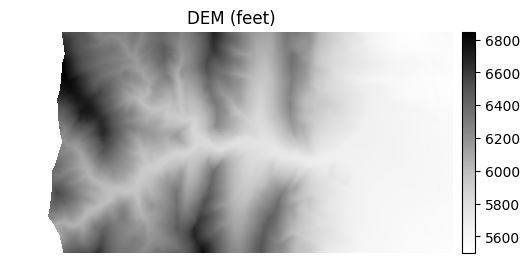

In [ ]:
# plot the masked data to make sure it makes sense:
fig, ax = plt.subplots(figsize=(6, 6))

ep.plot_bands(dem_feet_ma,
              cmap='Greys',
              title="DEM (feet)",
              scale=False,
              ax=ax)
ax.set_axis_off()
plt.show()

## Classifying raster data

So far, we've dealt with numpy arrays containg floating point values. You can also reclassify your data and convert your continous raster into a categorical raster, with each category represented by a unique integer.

For example, say that there is a lake in the region represented by our dem. We know that the water surface elevation in this lake is 5642 feet. How could you create a map of just water extents based on the DEM?

In [ ]:
# First, define bins that you want, and then classify the data
class_bins =[dem_feet_ma.min(),5642,  np.inf]

In [ ]:
# The np.digitize will create numeric cateogirles based on your class bins.
dem_waterline = np.digitize(dem_feet_ma, class_bins)

In [ ]:
# Note that you have an extra class in the data (0)
print(np.unique(dem_waterline))

[0 1 2]


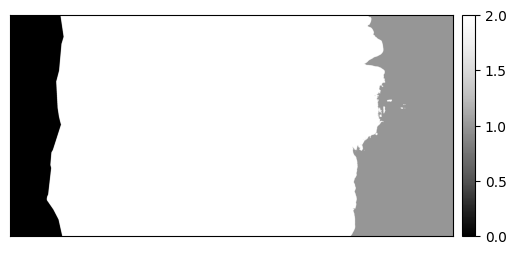

In [ ]:
# Plot newly classified and masked raster
fig, ax = plt.subplots(figsize=(6,6))
ep.plot_bands(dem_waterline,
               ax=ax,
               scale=False)
plt.show()

In [ ]:
print(dem_waterline)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


### Here, we've ended up with three classified values.
* 0 represents what was previously no data or masked regions of the raster,
* 1 represents water, and
* 2 represents land.

Often in raster manipulation, we want to use certain criteria to mask out raster data. Examples could include multiplying a multispectral satelite image by a cloud mask, or multiplying a SAR image by a terrain shadow mask. In this case, the "masks" that we're using represent seperate rasters that have been designed to tell us where we expect there to be limited information content in our raster. These "mask" layers have values of 1 for each pixel that we want to keep, and a no-data value for all other pixels. When you multiply the raster data by the mask, all the pixels that we want to keep are unchanged (value x 1 = value), and the pixels that we want to discard are converted to no-data (value x no-data = no-data).

### TASK 6: DEMs based on LiDAR will be inaccurate under standing water. Use your dem_waterline raster to create a "water_mask" for your DEM. This will be a raster with values of "1" where there is land, and no value everywhere else. Plot your water_mask.

In [ ]:
# Task 6: create water_mask
dem_watermask = np.where(dem_waterline == 1, 1, 0)

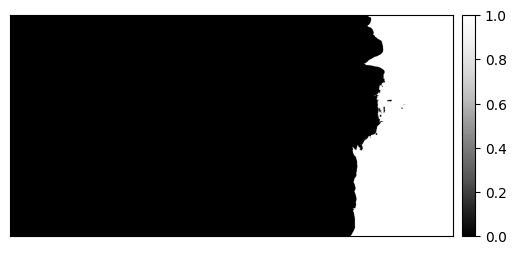

In [ ]:
# Task 6: plot water_mask
fig, ax = plt.subplots(figsize=(6,6))
ep.plot_bands(dem_watermask,
               ax=ax,
               scale=False)
plt.show()

### TASK 7: Use your water mask to "mask" all regions in your DEM that are underwater. Print out the minimum and maximum values and plot your masked DEM.

In [ ]:
#Task 7 create water_masked_DEM:
water_masked_DEM = np.ma.masked_where(dem_watermask == 0,
                                        dem_feet_ma,
                                        copy=True)

In [ ]:
#Task 7 print min and max:
water_masked_DEM.min()
water_masked_DEM.max()

5641.9946

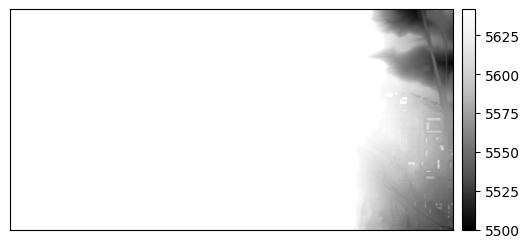

In [ ]:
#Task 7 plot water_masked_DEM
fig, ax = plt.subplots(figsize=(6,6))
ep.plot_bands(water_masked_DEM,
               ax=ax,
               scale=False)
plt.show()

## Imagery - Another Type of Raster Data
Another type of raster data that you may see is imagery. If you have used Google Maps or another mapping tool that has an imagery layer, you are looking at raster data. You can open and plot imagery data using Python as well.

Below you download and open up two NAIP multispectra images that that were collected before and after a forest fire that occured close to Nederland, Colorado.

Data Tip: NAIP data is high resolution imagery collected by aircraft from the United States Department of Agriculture every 2 years across the United States. Learn more about NAIP data in this chapter of the earth data science intermediate textbook: https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/intro-naip/

In [ ]:
# Download NAIP data
et.data.get_data(url="https://ndownloader.figshare.com/files/23070791")


Extracted output to /root/earth-analytics/data/earthpy-downloads/naip-before-after


'/root/earth-analytics/data/earthpy-downloads/naip-before-after'

In [ ]:
# Create a path for the NAIP imagery collected before the fire - notice it is a .tif file
naip_pre_fire_path = os.path.join("earthpy-downloads",
                                  "naip-before-after",
                                  "pre-fire",
                                  "crop",
                                  "m_3910505_nw_13_1_20150919_crop.tif")

naip_pre_fire_path

'earthpy-downloads/naip-before-after/pre-fire/crop/m_3910505_nw_13_1_20150919_crop.tif'

In [ ]:
# Open the data using rasterio
with rio.open(naip_pre_fire_path) as naip_prefire_src:
    naip_pre_fire = naip_prefire_src.read()

naip_pre_fire

array([[[113, 117, 137, ...,  54,  51,  74],
        [113, 117, 131, ...,  63,  54,  54],
        [111, 117, 120, ...,  78,  76,  52],
        ...,
        [191, 192, 193, ...,  58,  69,  76],
        [192, 192, 193, ...,  53,  62,  71],
        [193, 193, 193, ...,  51,  59,  66]],

       [[114, 114, 126, ...,  58,  54,  72],
        [114, 112, 120, ...,  70,  60,  58],
        [111, 114, 115, ...,  85,  87,  58],
        ...,
        [183, 184, 185, ...,  61,  75,  84],
        [184, 185, 185, ...,  56,  66,  78],
        [186, 186, 186, ...,  52,  58,  65]],

       [[ 80,  87,  95, ...,  55,  54,  63],
        [ 79,  83,  90, ...,  57,  55,  55],
        [ 81,  84,  87, ...,  62,  65,  55],
        ...,
        [161, 161, 163, ...,  54,  58,  64],
        [162, 164, 165, ...,  53,  58,  62],
        [165, 166, 166, ...,  51,  54,  57]],

       [[145, 143, 139, ...,  74,  47,  65],
        [145, 146, 139, ...,  98,  59,  57],
        [142, 144, 144, ..., 119, 107,  54],
        ..

In [ ]:
# Check dimenstions of the np.array
naip_pre_fire.shape

(4, 2312, 4377)

### TASK 8: In your own words, describe the physical quantities that are represented by the three values outputted by the `shape` function above.

The three values by shape show the dimensions of the array. They are 2312 rows, 4377 columns, and 4 bands.

### TASK 9: Read in and print the image metadata.

In [ ]:
# Task 9:
with rio.open(naip_pre_fire_path) as naip_prefire_src:
    naip_pre_fire = naip_prefire_src.read()

    naip_prefire_meta = naip_prefire_src.profile

naip_pre_fire
naip_prefire_meta

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 4377, 'height': 2312, 'count': 4, 'crs': CRS.from_epsg(6368), 'transform': Affine(1.0, 0.0, 457163.0,
       0.0, -1.0, 4426952.0), 'blockxsize': 4377, 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

### TASK 10: Using the image metadata, what is the spatial resolution of the NAIP imagery (area on ground represented by a single pixel)?

The spatial resolution is 1x1

Plotting imagery is a bit different because imagery is composed of multiple bands. While we won’t get into the specifics of bands and images in this lesson, you can see below that an image is composed of multiple layers of information.

You can plot each band individually as you see below using `plot_bands()`. Or you can plot a color image, similar to the image that your camera stores when you take a picture.

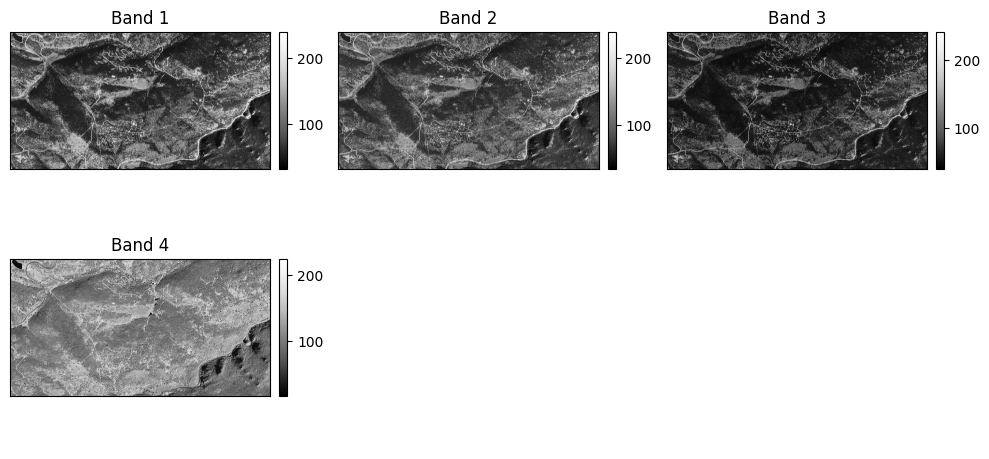

In [ ]:
# Plot each layer or band of the image separately
ep.plot_bands(naip_pre_fire, figsize=(10, 5))
plt.show()

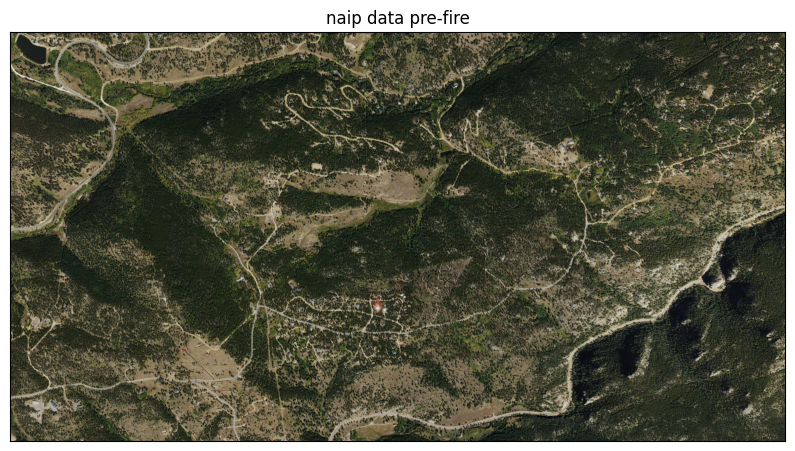

In [ ]:
# Plot of all NAIP Data Bands using earthpy plot_bands()
# Plot color image
ep.plot_rgb(naip_pre_fire,
            title="naip data pre-fire")
plt.show()

## Multispectral indices
In remote sensing, we sample specific bands along the electromagnetic spectrum because they give us unique information that allows us to distinguish between common earth surface features. A common practice in the processing of remotely sensed imagery is to arithmatically process multiple spectral bands containing unique information about the feature of interest into a single band raster to highlight certain earth surface feature elements. This new two dimentional image is called a multispectral index.

Examples of multispectral indices for detecting vegetation are given below, with R: Red band, G: Green, B: Blue, NIR: Near-infrared, and RE: Red-edge.


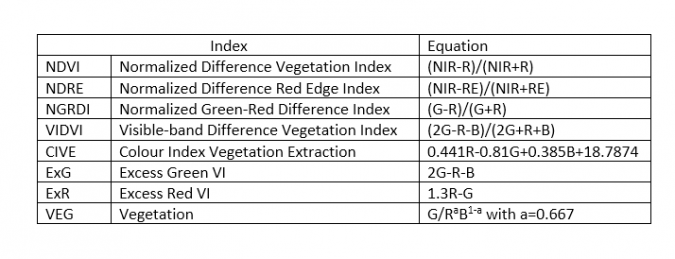

In [ ]:
from IPython import display
display.Image("https://www.gim-international.com/cache/1/d/a/c/6/1dac666728a9f8d07521a0094ff1dea58187ffa6.png", embed=True)

Using simply numpy arithmatic operations, we can flatten multispectral imagery into single-band multispectral index image. We can also easily compare multiple images.

In the following tasks, you will use numpy commands to do the following:

1. Calculate NDVI before and after the fire
2. Take the difference in NDVI before and after the fire.
3. Plot the change in NDVI caused by the fire

### TASK 11: Calculate NDVI
The normalized difference vegetation index is a metric of vegetation health calculated from the red and near infared bands of multispectral imagery.

```
NDVI = (NIR – Red) / (NIR + Red)
```

In the NAIP imagery, band 0 is the red band, and band 3 is the near infra-red band.

Create a new raster called NDVI_pre that calculates the NDVI in the pre-fire image. Make a plot of NDVI_pre.

In [ ]:
from ast import NodeVisitor
red_pre_fire=naip_pre_fire[0]
NIR_pre_fire=naip_pre_fire[3]

# Task 11: create NDVI_pre
NDVI_pre = (NIR_pre_fire - red_pre_fire) / (NIR_pre_fire + red_pre_fire)


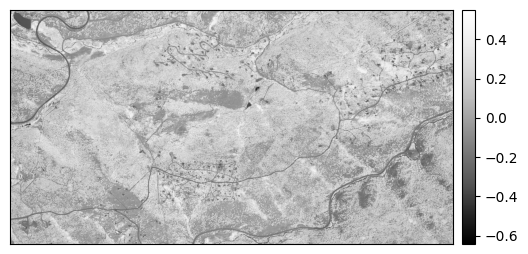

In [ ]:
#Task 11: plot NDVI_pre
fig, ax = plt.subplots(figsize=(6,6))
ep.plot_bands(NDVI_pre,
               ax=ax,
               scale=False)
plt.show()

### TASK 11: Plot post-fire data
In the code below, you see a path to a NAIP imagery of the region in Colorado that was collected after the fire in Colorado. Use that path to:

1. Open the post fire data
2. Plot a color version of data using plot_rgb()




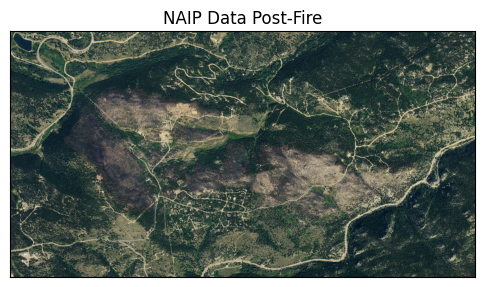

In [ ]:
# Add the code here to open the raster and read the numpy array inside it
# Create a path for the data file - notice it is a .tif file
naip_post_fire_path = os.path.join("earthpy-downloads",
                                   "naip-before-after",
                                   "post-fire",
                                   "crop",
                                   "m_3910505_nw_13_1_20170902_crop.tif")

# Task 11: open naip_post_fire
with rasterio.open(naip_post_fire_path) as naip_post_fire_src:
    # Read all bands (as an array)
    naip_post_fire = naip_post_fire_src.read()

# Task 11: plot naip_post_fire using ep.plot_rgb
fig, ax = plt.subplots(figsize=(6, 6))
ep.plot_rgb(naip_post_fire, ax=ax, title="NAIP Data Post-Fire")
plt.show()

### TASK 12: Fire kills vegetation. Make a map showing fire damage by comparing NDVI_pre fire with an NDVI_post fire:
1. Calculate NDVI post-fire (NDVI_post)
2. Take the difference of NDVI_pre and NDVI_post

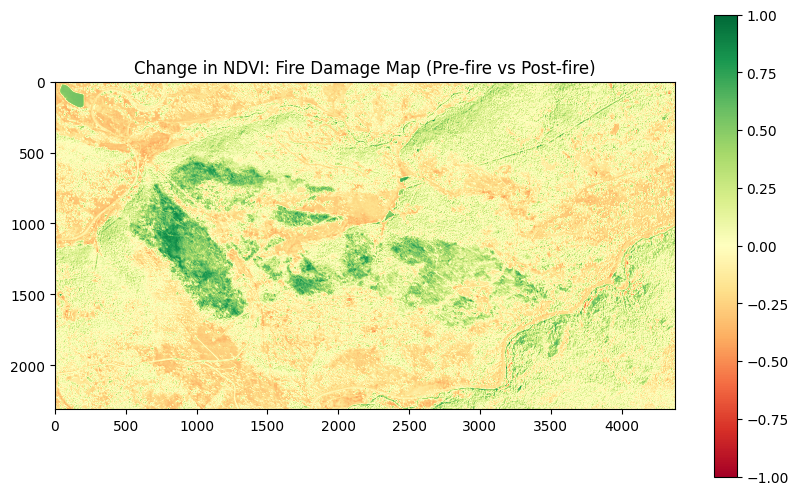

In [ ]:
# Task 11: create NDVI_post
naip_post_fire_path = os.path.join("earthpy-downloads",
                                   "naip-before-after",
                                   "post-fire",
                                   "crop",
                                   "m_3910505_nw_13_1_20170902_crop.tif")

with rasterio.open(naip_post_fire_path) as naip_post_fire_src:
    naip_post_fire = naip_post_fire_src.read()

nir_post = naip_post_fire[3].astype(float)
red_post = naip_post_fire[2].astype(float)

ndvi_post = (nir_post - red_post) / (nir_post + red_post)

ndvi_diff = NDVI_pre - ndvi_post

# Task 11: map change in NDVI
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(ndvi_diff, cmap='RdYlGn', vmin=-1, vmax=1)
ax.set_title("Change in NDVI: Fire Damage Map (Pre-fire vs Post-fire)")
fig.colorbar(im, ax=ax)
plt.show()

#EXTRA CREDIT: CALCULATE TOTAL BURNED AREA.
1. Plot a histogram of change in NDVI.
2. Use this histogram to set a threshold of values representing fire-impacted pixels.
3. Create a mask for fire-imapacted regions (burned area = 1, all other values are no-data).
4. Interpreting the Affine of the NAIP imagery, what was the total area imacted by the forest fire?

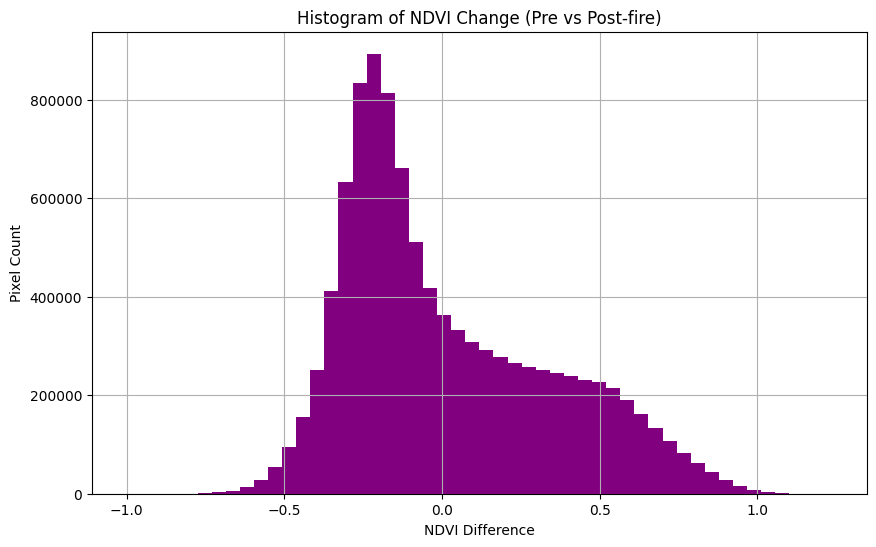

In [ ]:
# EC 1
plt.figure(figsize=(10, 6))
plt.hist(ndvi_diff.flatten(), bins=50, color='purple')
plt.title('Histogram of NDVI Change (Pre vs Post-fire)')
plt.xlabel('NDVI Difference')
plt.ylabel('Pixel Count')
plt.grid(True)
plt.show()

In [ ]:
# ec 2
threshold = -0.2

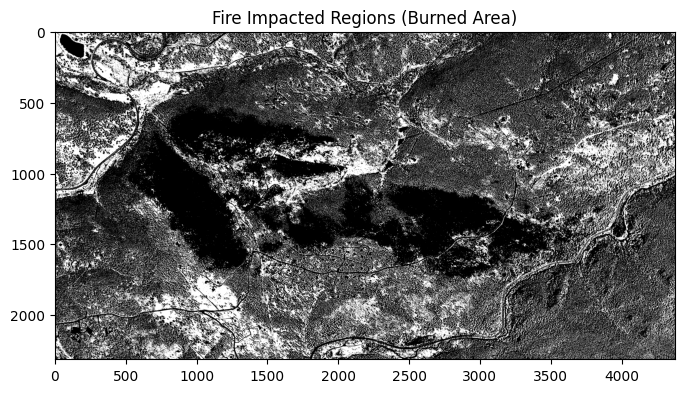

In [ ]:
# ec 3
burned_area_mask = np.where(ndvi_diff < threshold, 1, 0)

plt.figure(figsize=(8, 8))
plt.imshow(burned_area_mask, cmap='gray')
plt.title("Fire Impacted Regions (Burned Area)")
plt.show()

In [ ]:
# ec 4
pixel_size_x = naip_post_fire_src.transform[0]
pixel_size_y = -naip_post_fire_src.transform[4]

pixel_area = pixel_size_x * pixel_size_y

burned_area = np.sum(burned_area_mask) * pixel_area

print(f"Total Burned Area: {burned_area} square meters")

Total Burned Area: 3265864.0 square meters
